Cross-Validated Parameter Search
------------------------------------

In this section we present an open ended problem, cross-validated parameter search, and encourage students to try one of the previously mentioned techniques to parallelize it.  Any of `map`, `submit`, or collections like `spark` or `dask.bag` will work fine.


### Requirements

*  SciKit Learn
*  A parallel computing framework of your choice


### Application

We use grid search to find the optimal parameters for tuning a machine learning model.  This is slightly more complex than a map so we use `submit`.  We train the support vector classifier on handwritten digits using cross validation to avoid over-fitting.

As before we start with a sequential solution.

### Imports

In [38]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import ParameterSampler
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

### Data

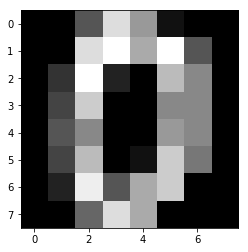

In [21]:
digits = load_digits()  # Collect Data

plt.imshow(digits.data[0].reshape(8, 8),  # Example element
           interpolation='nearest', cmap='gray');

### Utility functions

We use three utility functions that we provide in the `cv_params_demo.py` module. The `load_cv_split` function splits the data into a training and test set. `evaluate_one` fits the model and scores it over the data for a particular set of tuning parameters. `plot_results` visualizes the model score over the sampled parameter space.

In [22]:
from cv_params_demo import load_cv_split, evaluate_one, plot_results

### Parameters

`C`, `gamma`, and `tol` are all tunable parameters to the support-vector classifier, representing the penalty parameter of the error term, the kernel coefficient, and the stopping tolerance, respectively. Although `scikit-learn` can pick reasonable defaults for each of these, they can frequently be improved with additional knowledge of the data or by what we're doing here, randomly sampling the parameter space. We start with ten parameter samples, but can increase this after we've built our parallel solution.

In [23]:
param_grid = {
    'C': np.logspace(-10, 10, 1001),
    'gamma': np.logspace(-10, 10, 1001),
    'tol': np.logspace(-4, -1, 4),
}

param_samples = ParameterSampler(param_grid, 10)

list(param_samples)

[{'tol': 0.01, 'gamma': 1995262314.9688828, 'C': 20.892961308540407},
 {'tol': 0.001, 'gamma': 3.9810717055349776e-05, 'C': 1513561248.436207},
 {'tol': 0.0001, 'gamma': 0.0020892961308540407, 'C': 0.07244359600749892},
 {'tol': 0.1, 'gamma': 6.30957344480193e-06, 'C': 575439.9373371566},
 {'tol': 0.0001, 'gamma': 1.445439770745928e-05, 'C': 724435960.0749891},
 {'tol': 0.1, 'gamma': 27542287.033381745, 'C': 5.011872336272715e-09},
 {'tol': 0.1, 'gamma': 1.8197008586099826e-06, 'C': 0.0478630092322638},
 {'tol': 0.0001, 'gamma': 6.025595860743569e-09, 'C': 5.754399373371567e-09},
 {'tol': 0.001, 'gamma': 5.248074602497733, 'C': 0.010471285480508985},
 {'tol': 0.0001, 'gamma': 1.584893192461114e-06, 'C': 0.010964781961431873}]

### Split data for cross-validation

For now, we'll only build two randomly-chosen splits of the data for training and testing. We can increase this number after we've built our parallel solution.

In [24]:
from cv_params_demo import load_cv_split

cv_splits = [load_cv_split(i) for i in range(2)]
idx, (x_train, x_test, y_train, y_test) = cv_splits[0]
x_train, y_train

(array([[ 0.,  0.,  0., ..., 16., 16.,  6.],
        [ 0.,  3., 12., ..., 16.,  2.,  0.],
        [ 0.,  1., 10., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  4., ...,  0.,  0.,  0.],
        [ 0.,  0.,  6., ..., 11.,  0.,  0.]]), array([6, 5, 3, ..., 7, 7, 8]))

### Sequential cross validated parameter search

The below code sequentially loops over the randomly created data splits and parameter samples to create a list of scored samples over the parameter space.

In [25]:
print(len(cv_splits))
len(param_samples)

2


10

In [39]:
%%time



results = []

for split in cv_splits:
    for params in param_samples:
        result = evaluate_one(SVC, params, split)
        results.append(result)

CPU times: user 8.51 s, sys: 0 ns, total: 8.51 s
Wall time: 8.51 s


In [33]:
print(len(results))

20


With the default settings, the above cell should take ~10 seconds (wall) and ~9.5 s (user).

### Plot results

Which region of the parameter space is scoring well (higher is better)?  Are the number of samples we've computed sufficient to completely tune the model?  

Searching over more parameters would help to improve the intuition we can gain here.

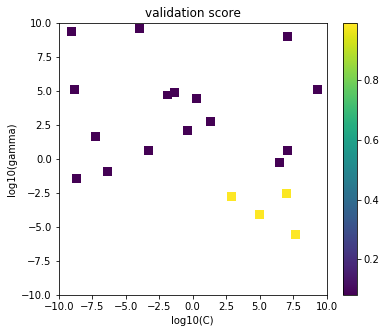

In [27]:
from cv_params_demo import plot_results

plot_results(results)

### Exercise: Parallel cross validated parameter search

Try using some of the techniques we've used before (or other techniques altogether) to parallelize the above computation.  

Afterwards, increase the number of parameters to help improve our understanding of the image.

Here we re-run the same space as above:

In [11]:
cv_splits = [load_cv_split(i) for i in range(2)]  # Increase the number 2 after parallel computation acheived
param_samples = ParameterSampler(param_grid, 10)    # Increase the number 10 after parallel computation acheived

print(len(cv_splits))
len(param_samples)

In [12]:
# TODO: compute results in parallel

In [13]:
#plot_results(results)

In [36]:
%%time
# %load solutions/cvgs-1.py
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor()

futures = []

parameters = list(param_samples)

for split in cv_splits:
    for params in parameters:
        future = e.submit(evaluate_one, SVC, params, split)
        futures.append(future)

results = [f.result() for f in futures]

print(len(results))

20
CPU times: user 9.37 s, sys: 7.81 ms, total: 9.38 s
Wall time: 1.38 s


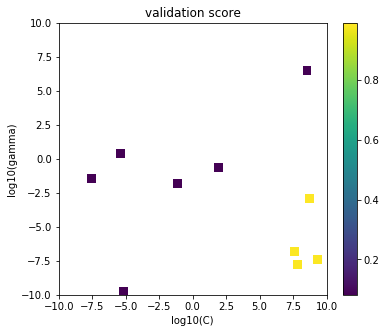

In [37]:
plot_results(results)

In [ ]:
cv_splits = [load_cv_split(i) for i in range(10)]  # Increase the number 2 after parallel computation acheived
param_samples = ParameterSampler(param_grid, 25)    # Increase the number 10 after parallel computation acheived

In [ ]:
%%time
# %load solutions/cvgs-1.py
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor()

futures = []

parameters = list(param_samples)

for split in cv_splits:
    for params in parameters:
        future = e.submit(evaluate_one, SVC, params, split)
        futures.append(future)

results = [f.result() for f in futures]


In [ ]:
plot_results(results)

# Reproducible(-ish) Version
Here we use a seed setting to make things more comparable?

In [48]:
%%time

# Serial Killer

np.random.seed(42) # for cv splits

cv_splits = [load_cv_split(i) for i in range(2)]
param_samples = ParameterSampler(param_grid, 10)

results = []

for split in cv_splits:
    for params in param_samples:
        result = evaluate_one(SVC, params, split)
        results.append(result)
        
print(len(results))

20
CPU times: user 8.54 s, sys: 0 ns, total: 8.54 s
Wall time: 8.54 s


This cell above took about 8 human (counting) seconds.

In [49]:
%%time

# Parallel (threads) Version:

e = ThreadPoolExecutor()

futures = []

parameters = list(param_samples)

np.random.seed(42) # for cv splits

for split in cv_splits:
    for params in parameters:
        future = e.submit(evaluate_one, SVC, params, split)
        futures.append(future)

results = [f.result() for f in futures]

print(len(results))

20
CPU times: user 11.6 s, sys: 6.77 ms, total: 11.6 s
Wall time: 1.51 s


The cell above tool less than 2 human (counting) seconds. :-)

# Spark Example Follows

In [ ]:
%%time
# %load solutions/cvgs-2.py
from pyspark import SparkContext
sc = SparkContext('local[4]')

cv_rdd = sc.parallelize(cv_splits)
param_rdd = sc.parallelize(list(param_samples))

rdd = param_rdd.cartesian(cv_rdd)
results = rdd.map(lambda tup: evaluate_one(SVC, tup[0], tup[1]))

results = results.collect()


In [ ]:
plot_results(results)